# Style Transfer

In this notebook, we will go through basics of neural style transfer. 

Here we will use [fastai](https://github.com/fastai/fastai/  "fastai's Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/style/transfer/2018/12/23/Magic-of-Style-Transfer/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Style%20Transfer/style_transfer_fastai.ipynb)

In [0]:
!pip install torch torchvision fastai

    100% |████████████████████████████████| 591.8MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61aee000 @  0x7f2b2eb932a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 26.1MB/s 
    100% |████████████████████████████████| 174kB 32.6MB/s 
    100% |████████████████████████████████| 2.0MB 6.4MB/s 
    100% |████████████████████████████████| 112kB 33.2MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e

Restart the kernel after running code above

In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving chicago.jpg to chicago.jpg


In [0]:
#uncomment this to upload kaggle.json

from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving starry-night.jpg to starry-night.jpg


In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import time
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

In [0]:
input_image = 'chicago.jpg'
style_input_image = 'starry-night.jpg'

In [0]:
width, height = Image.open(input_image).size      #input image dimension
img_nrows = 400
img_ncols = int(width * img_nrows / height)       #output image dimension

size = (img_nrows, img_ncols)

def preprocess_image(image_path):
    
    image = Image.open(image_path)
  
    tfms = transforms.Compose([transforms.Resize(size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
    img = tfms(image).unsqueeze(0)
    return img
    
def deprocess_tensor(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image
  

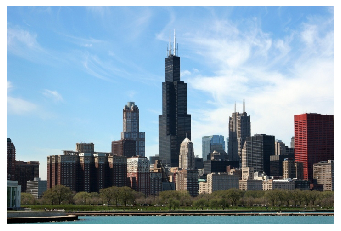

In [0]:
# content image
content = Image.open(input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(content)

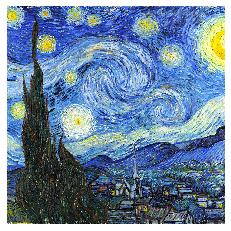

In [0]:
# style image
style = Image.open(style_input_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
plt.grid(visible=False)
imshow(style)

## Gatys et al 

Paper: [Link](https://arxiv.org/pdf/1508.06576.pdf)

Code Adapted from: [Here](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres-imagenet.ipynb)

In [0]:
content_image = preprocess_image(input_image).cuda()
style_image = preprocess_image(style_input_image).cuda()
generated_image = content_image.clone().requires_grad_(True).cuda()

assert (content_image.shape == style_image.shape == generated_image.shape)

In [0]:
model = models.vgg16(True).features.cuda().eval()
requires_grad(model, False)

In [0]:
for i,o in enumerate(children(model)):
  print (i, o)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace)
19 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
20 ReLU

In [0]:
content_layers = {'21': 'conv4_2'}
style_layers = {'0' : 'conv1_1', 
                '5' : 'conv2_1', 
                '10' : 'conv3_1', 
                '19' : 'conv4_1', 
                '24' : 'conv5_1'}
target_layers = {'0' : 'conv1_1', 
                '5' : 'conv2_1', 
                '10' : 'conv3_1', 
                '19' : 'conv4_1',
                '21' : 'conv4_2',
                '24' : 'conv5_1'}

In [0]:
def make_features(layer_dict, x):
    
    loss_features = [model[int(i)] for i, j in layer_dict.items()]
    hooks = hook_outputs(loss_features, detach=False)
    model(x)
    values = [o for o in hooks.stored]
    keys = layer_dict.values()
    return dict(zip(keys, values))

In [0]:
content_features = make_features(content_layers, content_image)
style_features = make_features(style_layers, style_image)

In [0]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram
  

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
# for displaying the target image, intermittently
show_every = 400
content_weight = 1
style_weight = 1e5
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# iteration hyperparameters
optimizer = optim.Adam([generated_image], lr=0.003)
iterations = 4000  # decide how many iterations to update your image (5000)

for i in range(iterations):
    start_time = time.time()
    # target features from generated image
    target_features = make_features(target_layers, generated_image)
    
    # content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # style loss
    style_loss = 0
   
    for layer in style_weights:

        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        n, c, h, w = target_feature.shape
        
        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        style_loss += layer_style_loss / (c * h * w)
        
    # total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update generated image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    end_time = time.time()
    # display intermediate images and print the loss
    if  i % show_every == 0:
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
        print('Total loss: ', total_loss.item())


Iteration 0 completed in 0s
Total loss:  276984.6875
Iteration 400 completed in 0s
Total loss:  22238.4296875
Iteration 800 completed in 0s
Total loss:  10441.078125
Iteration 1200 completed in 0s
Total loss:  6939.1552734375
Iteration 1600 completed in 0s
Total loss:  5333.138671875
Iteration 2000 completed in 0s
Total loss:  4456.6279296875
Iteration 2400 completed in 0s
Total loss:  3847.205078125
Iteration 2800 completed in 0s
Total loss:  3445.330078125
Iteration 3200 completed in 0s
Total loss:  3161.6982421875
Iteration 3600 completed in 0s
Total loss:  2934.537109375


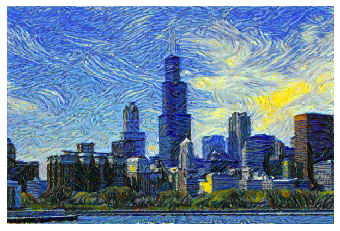

In [0]:
img = deprocess_tensor(generated_image)
plt.xticks([])
plt.yticks([])
plt.grid(visible=False)
imshow(img)